In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU terdeteksi")
    except RuntimeError as e:
        print(e)
else:
  print("GPU tidak ada")

GPU tidak ada


In [36]:
train_dir = "../dataset/train"
val_dir   = "../dataset/val"
test_dir  = "../dataset/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4 
CLASS_NAMES_ORDER = ["bika ambon", "kerak telur", "papeda", "plecing kangkung"]
EPOCHS = 30

print("Target classes:", CLASS_NAMES_ORDER)

Target classes: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


In [37]:
def load_data(directory, img_size=(224,224), batch_size=32, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',           
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return ds

train_ds_raw = load_data(train_dir, IMG_SIZE, BATCH_SIZE, shuffle=True)
val_ds_raw   = load_data(val_dir,   IMG_SIZE, BATCH_SIZE, shuffle=False)
test_ds_raw  = load_data(test_dir,  IMG_SIZE, BATCH_SIZE, shuffle=False)

print("class_names detected:", train_ds_raw.class_names)


Found 241 files belonging to 4 classes.
Found 29 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
class_names detected: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


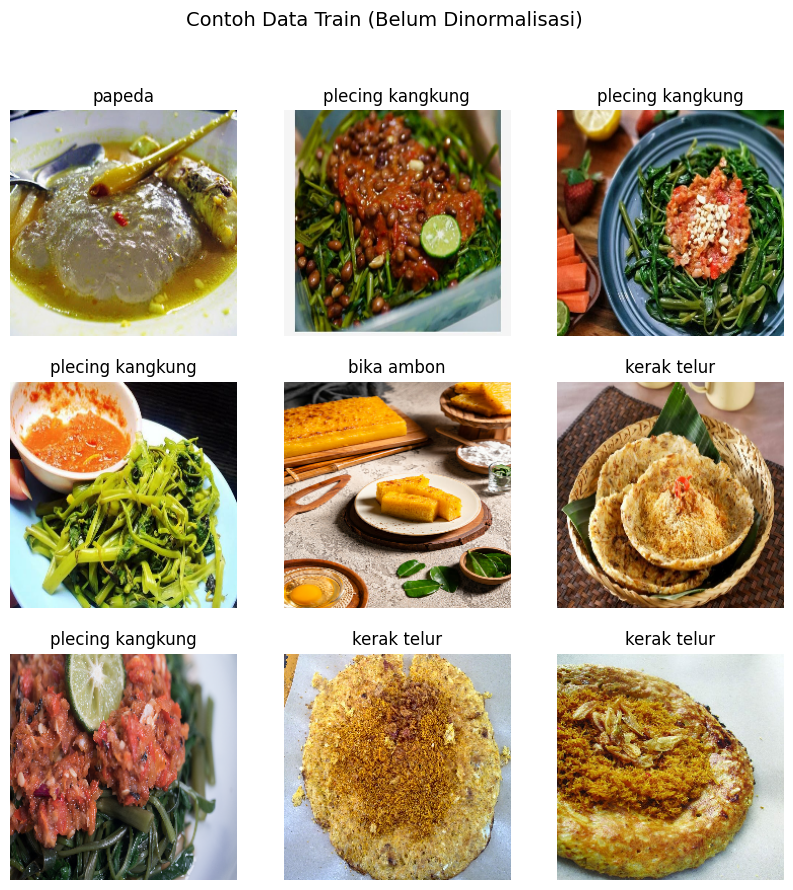

In [38]:
def visualize_data(dataset, class_names, n_images=9, title="Contoh Data"):
    plt.figure(figsize=(10,10))
    for images, labels in dataset.take(1):
        for i in range(n_images):
            ax = plt.subplot(3,3,i+1)

            img = images[i].numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            plt.imshow(img)
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

visualize_data(train_ds_raw, train_ds_raw.class_names, n_images=9, title="Contoh Data Train (Belum Dinormalisasi)")


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, shuffle=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalisasi [0..1]
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, shuffle=True)
val_ds   = prepare_dataset(val_ds_raw,   shuffle=True)
test_ds  = prepare_dataset(test_ds_raw,  shuffle=True)

train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches   = tf.data.experimental.cardinality(val_ds).numpy()
test_batches  = tf.data.experimental.cardinality(test_ds).numpy()

print("Jumlah batch train:", train_batches)
print("Jumlah batch val  :", val_batches)
print("Jumlah batch test :", test_batches)



Jumlah batch train: 8
Jumlah batch val  : 1
Jumlah batch test : 1


In [40]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# base VGG16 tanpa pretrained
base_vgg = VGG16(
    weights=None,               
    include_top=False,          
    input_shape=IMG_SIZE + (3,)
)

# Rangkaian model end-to-end:
inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_image")

x = data_augmentation(inputs)                  
x = layers.Rescaling(1./255)(x)               
features = base_vgg(x, training=True)         

# pakai GlobalAveragePooling2D agar parameter efisien
x = layers.GlobalAveragePooling2D()(features)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASS_NAMES_ORDER), activation='softmax')(x)

vgg_model = models.Model(inputs=inputs, outputs=outputs, name="VGG16_CustomHead")

vgg_model.summary()



Model: "VGG16_CustomHead"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 14,847,044 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # lebih kecil biar stabil
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [42]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop]
)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
acc      = history_vgg.history['accuracy']
val_acc  = history_vgg.history['val_accuracy']
loss     = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs_range = range(1, len(acc)+1)

# simpan dataframe (dibutuhkan rubrik)
history_df = pd.DataFrame({
    "epoch": list(epochs_range),
    "train_accuracy": acc,
    "val_accuracy": val_acc,
    "train_loss": loss,
    "val_loss": val_loss
})
print(history_df)

   epoch  train_accuracy  val_accuracy  train_loss  val_loss
0      1        0.265560      0.241379    2.489595  1.386854
1      2        0.236515      0.241379    1.392970  1.386291
2      3        0.211618      0.275862    1.387335  1.385853
3      4        0.261411      0.275862    1.386690  1.385938
4      5        0.261411      0.275862    1.386635  1.385926
5      6        0.273859      0.275862    1.386144  1.385955
6      7        0.236515      0.275862    1.386445  1.385953
7      8        0.261411      0.275862    1.386451  1.385950
8      9        0.248963      0.275862    1.386398  1.385971
9     10        0.265560      0.275862    1.386289  1.385969


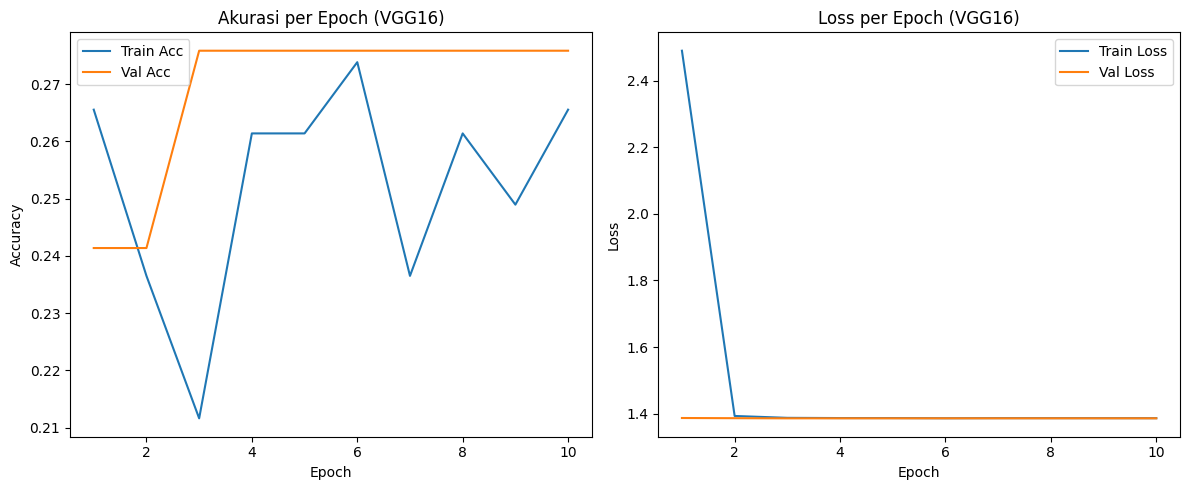

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Akurasi per Epoch (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss per Epoch (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_ds)
print("Test Loss (VGG16):", test_loss)
print("Test Acc  (VGG16):", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 1.3863
Test Loss (VGG16): 1.3863143920898438
Test Acc  (VGG16): 0.25


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds_raw:
    # normalisasi dulu manual biar sama kayak training
    imgs_norm = (tf.cast(images, tf.float32) / 255.0).numpy()
    probs = vgg_model.predict(imgs_norm)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("=== Classification Report (VGG16) ===")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES_ORDER))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES_ORDER,
    yticklabels=CLASS_NAMES_ORDER
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16 (Tanpa Pretrained)")
plt.show()

In [ ]:
for images, labels in test_ds_raw.shuffle(100).take(1):
    raw_imgs = images.numpy().astype("uint8")  # agar ditampilkan asli

    imgs_norm = (tf.cast(images, tf.float32) / 255.0).numpy()
    probs = vgg_model.predict(imgs_norm)
    preds = np.argmax(probs, axis=1)

    plt.figure(figsize=(12,12))
    for i in range(min(9, len(raw_imgs))):
        plt.subplot(3,3,i+1)
        plt.imshow(raw_imgs[i])
        true_label = CLASS_NAMES_ORDER[labels[i].numpy()]
        pred_label = CLASS_NAMES_ORDER[preds[i]]
        conf = np.max(probs[i]) * 100
        plt.title(f"T:{true_label}\nP:{pred_label}\n{conf:.1f}%")
        plt.axis("off")
    plt.suptitle("Prediksi Model VGG16 pada Data Test", fontsize=16)
    plt.tight_layout()
    plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path, class_names, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    probs = model.predict(img_arr)
    pred_idx = np.argmax(probs)
    pred_label = class_names[pred_idx]
    confidence = np.max(probs) * 100

    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediksi: {pred_label}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


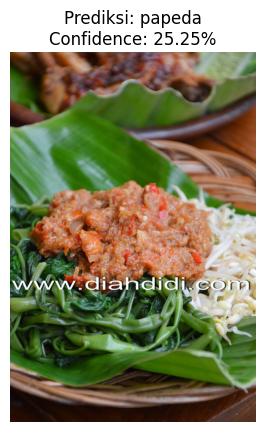

In [ ]:
predict_single_image(
    vgg_model,
    "../predict_samples/test/kerak telur/test9.jpg",
    CLASS_NAMES_ORDER,
    img_size=IMG_SIZE
)

In [ ]:
vgg_model.save("../models/BestModel_VGG16_A_KERAS.h5")
print("Model VGG16 berhasil disimpan")

Model VGG16 disimpan ke ../models/BestModel_VGG16_A_KERAS.h5
